In [1]:
from os import path
import numpy as np
import gym
from gym import spaces
from gym.error import DependencyNotInstalled
from gym.utils.renderer import Renderer
from typing import Optional

/home/oscar.kremer/miniconda3/envs/deep-tweezer/lib/python3.6/site-packages/gym/core.py:26: UserWarning: WARN: Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+
  "Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+"


In [2]:
from os import path
import numpy as np
import gym
from gym import spaces
from gym.error import DependencyNotInstalled
from gym.utils.renderer import Renderer


class Tweezer(gym.Env):
    """
       ### Description
    The inverted pendulum swingup problem is based on the classic problem in control theory.
    The system consists of a pendulum attached at one end to a fixed point, and the other end being free.
    The pendulum starts in a random position and the goal is to apply torque on the free end to swing it
    into an upright position, with its center of gravity right above the fixed point.
    The diagram below specifies the coordinate system used for the implementation of the pendulum's
    dynamic equations.
    ![Pendulum Coordinate System](./diagrams/pendulum.png)
    -  `x-y`: cartesian coordinates of the pendulum's end in meters.
    - `theta` : angle in radians.
    - `tau`: torque in `N m`. Defined as positive _counter-clockwise_.
    ### Action Space
    The action is a `ndarray` with shape `(1,)` representing the torque applied to free end of the pendulum.
    | Num | Action | Min  | Max |
    |-----|--------|------|-----|
    | 0   | Torque | -2.0 | 2.0 |
    ### Observation Space
    The observation is a `ndarray` with shape `(3,)` representing the x-y coordinates of the pendulum's free
    end and its angular velocity.
    | Num | Observation      | Min  | Max |
    |-----|------------------|------|-----|
    | 0   | x = cos(theta)   | -1.0 | 1.0 |
    | 1   | y = sin(angle)   | -1.0 | 1.0 |
    | 2   | Angular Velocity | -8.0 | 8.0 |
    ### Rewards
    The reward function is defined as:
    *r = -(theta<sup>2</sup> + 0.1 * theta_dt<sup>2</sup> + 0.001 * torque<sup>2</sup>)*
    where `$\theta$` is the pendulum's angle normalized between *[-pi, pi]* (with 0 being in the upright position).
    Based on the above equation, the minimum reward that can be obtained is
    *-(pi<sup>2</sup> + 0.1 * 8<sup>2</sup> + 0.001 * 2<sup>2</sup>) = -16.2736044*,
    while the maximum reward is zero (pendulum is upright with zero velocity and no torque applied).
    ### Starting State
    The starting state is a random angle in *[-pi, pi]* and a random angular velocity in *[-1,1]*.
    ### Episode Termination
    The episode terminates at 200 time steps.
    ### Arguments
    - `g`: acceleration of gravity measured in *(m s<sup>-2</sup>)* used to calculate the pendulum dynamics.
      The default value is g = 10.0 .
    ```
    gym.make('Pendulum-v1', g=9.81)
    ```
    ### Version History
    * v1: Simplify the math equations, no difference in behavior.
    * v0: Initial versions release (1.0.0)
    """

    metadata = {
        "render_modes": ["human", "rgb_array", "single_rgb_array"],
        "render_fps": 30,
    }

    def __init__(self, render_mode: Optional[str] = None):
        avogrado = 6.02*(10**23) # 1/mol
        kB = 1.380649*(10**-23) # m^2 kg /(s^2 K)
        c = 3*(10**8) # m/s
        self.m_gas_molecule = 0.02897/avogrado  # kg
        self.max_voltage = 10.0 # V
        self.m = 1.14*(10**-18) # kg
        self.d = 11*(10**-3) # m
        self.R = 50*(10**-9) # m
        self.T = 273.5 + 25 # K
        self.pressure = 10**3 # Pa
        self.Q = 2*(10**4)*(1.6*(10**-19))*np.power(self.R/(2.5*10**-6), 3) # Coulomb
        self.gas_velocity = np.sqrt((3*kB*self.T/self.m_gas_molecule)) # m/s
        self.omega_0 = 2*np.pi*150*(10**3) # rad/s
        self.gamma = 15.8*(np.power(self.R, 2)*self.pressure)/self.gas_velocity # kg/s
        self.dt = 5*10**-7 # s
        self.noise_amplitude = np.sqrt(2*kB*self.T*self.gamma) # N
        self.std_noise = 1 # adimensional
        self.render_mode = render_mode
        self.renderer = Renderer(self.render_mode, self._render)
        self.screen_dim = 500
        self.screen = None
        self.clock = None
        self.isopen = True

        high = np.array([10**-3, 1000], dtype=np.float32)
        # This will throw a warning in tests/envs/test_envs in utils/env_checker.py as the space is not symmetric
        #   or normalised as max_torque == 2 by default. Ignoring the issue here as the default settings are too old
        #   to update to follow the openai gym api
        self.action_space = spaces.Box(
            low=-self.max_voltage, high=self.max_voltage, shape=(1,), dtype=np.float32
        )
        self.observation_space = spaces.Box(shape=(2,), 
                                            low=-high, 
                                            high=high, 
                                            dtype=np.float32)

    def white_noise(self):
        return self.noise_amplitude*np.random.normal(0, self.std_noise)

    def step(self, u):
        y, ydot = self.state  # th := theta
        gamma = self.gamma
        omega_0 = self.omega_0
        m = self.m
        Q = self.Q 
        d = self.d 
        u = np.clip(u, -self.max_voltage, self.max_voltage)[0]
        eletric_F = Q*u/d
        self.last_u = u  # for rendering
        costs = -100*ydot**2 -u**2
        random_force = self.white_noise()
        a_i = (1/m)*(u + self.white_noise()) - np.power(self.omega_0, 2)*y - gamma*ydot
        v_i_half = ydot + a_i*self.dt
        x_i_plus = y + v_i_half*self.dt
        a_i_plus = (1/m)*(u + self.white_noise()) - np.power(self.omega_0, 2)*x_i_plus - gamma*v_i_half
        v_i_three_half = v_i_half + a_i_plus*self.dt
        self.state = np.array([x_i_plus, v_i_three_half])
#        self.renderer.render_step()
        return self._get_obs(), costs, False, {}

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        return_info: bool = False,
        options: Optional[dict] = None
    ):
        super().reset(seed=seed)
        high = np.array([20*10**-9, 0.01])
        self.state = self.np_random.uniform(low=-high, high=high)
        self.last_u = None
        self.renderer.reset()
        self.renderer.render_step()
        if not return_info:
            return self._get_obs()
        else:
            return self._get_obs(), {}

    def _get_obs(self):
        y, ydot = self.state
        return np.array([y, ydot], dtype=np.float32)

    def render(self, mode="human"):
        if self.render_mode is not None:
            return self.renderer.get_renders()
        else:
            return self._render(mode)

    def _render(self, mode="human"):
        assert mode in self.metadata["render_modes"]
        try:
            import pygame
            from pygame import gfxdraw
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[classic_control]`"
            )

        if self.screen is None:
            pygame.init()
            if mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode(
                    (self.screen_dim, self.screen_dim)
                )
            else:  # mode in {"rgb_array", "single_rgb_array"}
                self.screen = pygame.Surface((self.screen_dim, self.screen_dim))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        self.surf = pygame.Surface((self.screen_dim, self.screen_dim))
        self.surf.fill((255, 255, 255))

        bound = 2.2
        scale = self.screen_dim / (bound * 2)
        offset = self.screen_dim // 2

        rod_length = 1 * scale
        rod_width = 0.2 * scale
        l, r, t, b = 0, rod_length, rod_width / 2, -rod_width / 2
        coords = [(l, b), (l, t), (r, t), (r, b)]
        transformed_coords = []
        for c in coords:
            c = pygame.math.Vector2(c).rotate_rad(self.state[0] + np.pi / 2)
            c = (c[0] + offset, c[1] + offset)
            transformed_coords.append(c)
        gfxdraw.aapolygon(self.surf, transformed_coords, (204, 77, 77))
        gfxdraw.filled_polygon(self.surf, transformed_coords, (204, 77, 77))

        gfxdraw.aacircle(self.surf, offset, offset, int(rod_width / 2), (204, 77, 77))
        gfxdraw.filled_circle(
            self.surf, offset, offset, int(rod_width / 2), (204, 77, 77)
        )

        rod_end = (rod_length, 0)
        rod_end = pygame.math.Vector2(rod_end).rotate_rad(self.state[0] + np.pi / 2)
        rod_end = (int(rod_end[0] + offset), int(rod_end[1] + offset))
        gfxdraw.aacircle(
            self.surf, rod_end[0], rod_end[1], int(rod_width / 2), (204, 77, 77)
        )
        gfxdraw.filled_circle(
            self.surf, rod_end[0], rod_end[1], int(rod_width / 2), (204, 77, 77)
        )

        fname = path.join(path.dirname(__file__), "assets/clockwise.png")
        img = pygame.image.load(fname)
        if self.last_u is not None:
            scale_img = pygame.transform.smoothscale(
                img,
                (scale * np.abs(self.last_u) / 2, scale * np.abs(self.last_u) / 2),
            )
            is_flip = bool(self.last_u > 0)
            scale_img = pygame.transform.flip(scale_img, is_flip, True)
            self.surf.blit(
                scale_img,
                (
                    offset - scale_img.get_rect().centerx,
                    offset - scale_img.get_rect().centery,
                ),
            )

        # drawing axle
        gfxdraw.aacircle(self.surf, offset, offset, int(0.05 * scale), (0, 0, 0))
        gfxdraw.filled_circle(self.surf, offset, offset, int(0.05 * scale), (0, 0, 0))

        self.surf = pygame.transform.flip(self.surf, False, True)
        self.screen.blit(self.surf, (0, 0))
        if mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        else:  # mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False

In [3]:
env = Tweezer()

In [4]:
from tqdm import tqdm

In [88]:

states = []
s = env.reset()
for i in tqdm(range(10**6)):
    sP, r, done, _ = env.step(np.array([0]))
    states.append(sP)
#    if i > 99000:
#        print(sP)
states = np.array(states)

100%|██████████| 1000000/1000000 [00:27<00:00, 37005.68it/s]


In [89]:
env.gamma

7.792892066031865e-14

In [90]:
np.array(states[:,1])

array([ 0.0124015 ,  0.01615248,  0.01274005, ..., -0.02663928,
       -0.01209167,  0.00783874], dtype=float32)

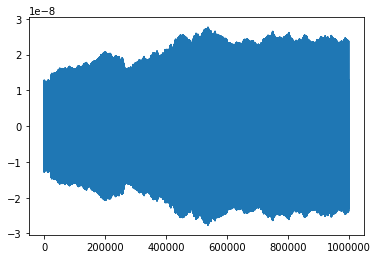

In [91]:
plt.plot(states[:,0])
plt.show()

In [92]:
import matplotlib.pyplot as plt

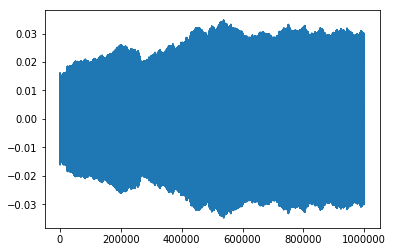

In [93]:
plt.plot(states[:,1])
plt.show()